<a href="https://colab.research.google.com/github/biggity2bit/colab/blob/master/bernt_politifact_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [0]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

In [3]:
# Basic libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NaiveBayes").getOrCreate()

In [5]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://news-detector-project.s3.us-east-2.amazonaws.com/FakeNews.csv"
spark.sparkContext.addFile(url)
df_fake = spark.read.csv(SparkFiles.get("FakeNews.csv"), sep=",", header=True)

# Show DataFrame
df_fake.show()

+--------------------+--------------------+--------------+-----------+
|               title|         articletext|articlesubject|articledate|
+--------------------+--------------------+--------------+-----------+
| Donald Trump Sen...|Donald Trump just...|          News|  31-Dec-17|
| Drunk Bragging T...|House Intelligenc...|          News|  31-Dec-17|
| Sheriff David Cl...|On Friday, it was...|          News|  30-Dec-17|
| Trump Is So Obse...|On Christmas day,...|          News|  29-Dec-17|
| Pope Francis Jus...|Pope Francis used...|          News|  25-Dec-17|
| Racist Alabama C...|The number of cas...|          News|  25-Dec-17|
| Fresh Off The Go...|Donald Trump spen...|          News|  23-Dec-17|
| Trump Said Some ...|In the wake of ye...|          News|  23-Dec-17|
| Former CIA Direc...|Many people have ...|          News|  22-Dec-17|
| WATCH: Brand-New...|Just when you mig...|          News|  21-Dec-17|
| Papa John’s Foun...|A centerpiece of ...|          News|  21-Dec-17|
| WATC

In [6]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://news-detector-project.s3.us-east-2.amazonaws.com/TrueNews.csv"
spark.sparkContext.addFile(url)
df_true = spark.read.csv(SparkFiles.get("TrueNews.csv"), sep=",", header=True)

# Show DataFrame
df_true.show()

+--------------------+--------------------+--------------------+------------+
|               title|         articletext|      articlesubject| articledate|
+--------------------+--------------------+--------------------+------------+
|As U.S. budget fi...|WASHINGTON (Reute...|        politicsNews|   31-Dec-17|
|U.S. military to ...|WASHINGTON (Reute...|        politicsNews|   29-Dec-17|
|Senior U.S. Repub...|WASHINGTON (Reute...|        politicsNews|   31-Dec-17|
|FBI Russia probe ...|WASHINGTON (Reute...|        politicsNews|   30-Dec-17|
|Trump wants Posta...|SEATTLE/WASHINGTO...|        politicsNews|   29-Dec-17|
|White House, Cong...|WEST PALM BEACH, ...|        politicsNews|   29-Dec-17|
|Trump says Russia...|WEST PALM BEACH, ...|        politicsNews|   29-Dec-17|
|Factbox: Trump on...|The following sta...|        politicsNews|   29-Dec-17|
|Trump on Twitter ...|The following sta...|        politicsNews|   29-Dec-17|
|Alabama official ...|WASHINGTON (Reute...|        politicsNews|

In [7]:
# import pandas as pd
fake_df = df_fake.toPandas() 
true_df = df_true.toPandas() 
true_df.head()

,title,articletext,articlesubject,articledate
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17


In [8]:
# Assign values to true and false
fake_df['label'] = 1
true_df['label'] = 0
true_df.head()

,title,articletext,articlesubject,articledate,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17,0


In [10]:
# Create a new dataframe with only the information we need (the text of articles and the true/false values):
df1 = pd.concat([fake_df[['articletext', 'label']], true_df[['articletext', 'label']]], axis=0)

print("Shape:", df1.shape)
df1.tail()

Shape: (44937, 2)


,articletext,label
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,0
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",0
21414,MINSK (Reuters) - In the shadow of disused Sov...,0
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,0
21416,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,0


In [0]:
# Create a function to claen the dataframes:
def clean_data_text(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='articletext', inplace=True)
    
    # Remove punctation
    dataframe['articletext'] = dataframe['articletext'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['articletext'] = dataframe['articletext'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['articletext'] = dataframe['articletext'].str.replace('  ',' ')
    dataframe['articletext'] = dataframe['articletext'].str.replace('  ',' ')

    # Transform all text to lowercase
    dataframe['articletext'] = dataframe['articletext'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

In [13]:
# Call `clean_data_text(dataframe)` function
clean_data_text(df1)

New shape: (38628, 2)


,articletext,label
0,donald trump just couldn t wish all americans ...,1
1,house intelligence committee chairman devin nu...,1
2,on friday it was revealed that former milwauke...,1
3,on christmas day donald trump announced that h...,1
4,pope francis used his annual christmas day mes...,1


In [0]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer

# Create all the features to the data set
pos_neg_to_num = StringIndexer(inputCol='label',outputCol='label')
tokenizer = Tokenizer(inputCol="articletext", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')

In [0]:
# Create a and run a data processing Pipeline
from pyspark.ml import Pipeline
data_prep_pipeline = Pipeline(stages=[tokenizer, stopremove, hashingTF, idf, clean_up])

In [23]:
# Convert pandas dataframe back to Pyspark:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

spark_df1 = spark.createDataFrame(df1)
spark_df1.head()

Row(articletext='donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and the very dishonest fake news media the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year president angry pants tweeted  will be a great year for america as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year  will be a great year for america donald j trump realdonaldtrump december   trump s tweet went down about as welll as you d expect what kind of president sends a new year s greeting like this despicable petty infantile gibberish only trump his lack of decency won t even allow him to rise above the gu

In [24]:
# Fit and transform the pipeline
cleaner = data_prep_pipeline.fit(spark_df1)
cleaned = cleaner.transform(spark_df1)

Py4JJavaError: ignored

In [0]:
# define function for graphs
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

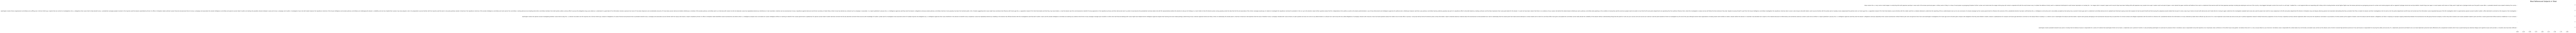

In [26]:
# Set x values: # of posts for both datasets
df_domain = df1['articletext'].value_counts() 
df_domain = df_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_domain_index = list(df_domain.index)

# Call function
bar_plot(df_domain.values, df_domain_index, 'Most Referenced Subjects in Total:' ,'r')

So I need to lookup our class examples and put that code in here. 
I need to also figure out how to load my test csv into a spark dataframe so I can test it. 
There's a lot going on here, and sometimes it's difficult to follow. 


Model 2: TfidfVectorize & Logistic Regression

In [27]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

# @TODO REMOVE GRID SEARCH FOR NOW

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

TypeError: ignored